# Text analysis workbook


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ICa2nh3mbflJCrJ4oKNUHWTZ9_vTJw8F?usp=sharing) (Fix link later!)

In [ ]:
# TODO add colab explanation

# Part 1: Set-up
At the beginning of this notebook, we need to set up all of the libraries/packages (reusable python-programs other people have written) that we are going to use during. For this we use a common python-package manager called 'pip'. Pip takes care of downloading the right versions, and installing them on our computer, which in this case is a server that's standing in a google

In [139]:
!pip install pandas
!pip install pyalex
!pip install umap-learn
!pip install datamapplot
!pip install sentence-transformers
!pip install seaborn
!pip install genieclust
!pip install litellm
!pip install opinionated


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached opinionated-0.0.3.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached colormaps-0.4.2-py3-none-any.whl.metadata (4.8 kB)
Using cached opinionated-0.0.3.0-py3-none-any.whl (16.1 MB)
Using cached colormaps-0.4.2-py3-none-any.whl (727 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Part 2: Imports

In [141]:

# Our data-handling library:
import pandas as pd

# Our visualisation library:
import matplotlib.pyplot as plt
import seaborn as sns


# Our numerical library:
import numpy as np

import os


import pyalex



# Our mapping library:
import umap
import datamapplot

# Libraries for llms
import sentence_transformers
import litellm

# Library for prettier graphics:
import opinionated
plt.style.use('opinionated_rc')
import colormaps as colormaps #https://pratiman-91.github.io/colormaps/



from utils.openalex_utils import openalex_url_to_pyalex_query, process_records_to_df, get_records_from_dois, openalex_url_to_filename, download_openalex_records

# Part 3: Getting data

## Part 3.1 OpenAlex-datasets.

In [ ]:
openalex_url = 'https://openalex.org/works?page=1&filter=title_and_abstract.search:Aristotle,language:languages/en'

dataset_df = download_openalex_records(openalex_url,
                                       reduce_sample=True, 
                                       sample_reduction_method="n random samples", 
                                       sample_size=5000, 
                                       seed_value="42")


# We filter for works that have an abstract:
dataset_df = dataset_df[dataset_df['abstract'].str.len() > 10]

text_data = list(dataset_df['abstract'])
year_data = dataset_df['publication_year']
title_data = dataset_df['title']

used_dataset = "OpenAlex-query"






We can take a look at the data, by displaying the dataframe-object:

In [ ]:
display(dataset_df)

# Part 3.2 Stanford-Encyclopedia dataset

In [127]:
import requests
import zipfile
from pathlib import Path

# Download and extract if needed
stanford_folder = Path("stanford-encyclopedia")
if not stanford_folder.exists():
    zip_data = requests.get("https://github.com/MNoichl/data-driven-philosophy-GAP2025/raw/refs/heads/main/stanford-encyclopedia.zip").content
    with zipfile.ZipFile(zipfile.io.BytesIO(zip_data)) as zip_ref:
        zip_ref.extractall(".")

# Load data
text_data = [open(f, encoding='utf-8').read() for f in stanford_folder.glob("*.md")]
title_data = [f.stem for f in stanford_folder.glob("*.md")]
used_dataset = "Stanford Encyclopedia"

# Part 4: Using a language model 
We are now going to use a text-embedding model (a relatively small large language model) to transform the texts into a format which is easier to analyze mathematically. 


(BERT explaination.)  

https://www.sbert.net/docs/sentence_transformer/pretrained_models.html 

In [128]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('thenlper/gte-small')
embeddings = model.encode(text_data,show_progress_bar=True)


Batches: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]


This is what the resulting embeddings look like:


In [129]:
print(embeddings)

[[-0.02745944  0.04221099  0.01376158 ... -0.01439601  0.06682028
   0.02351166]
 [-0.04714916  0.01006269  0.03506079 ...  0.00196781  0.02477524
   0.03770122]
 [-0.00467115  0.02150382  0.00719122 ... -0.03379769  0.05280037
   0.01066221]
 ...
 [-0.01956707  0.02080425  0.04293629 ...  0.01195393  0.04290305
   0.0431272 ]
 [ 0.00416075  0.04052113  0.07299885 ...  0.00168543  0.02456463
   0.03964555]
 [-0.03597482  0.04142086  0.00460767 ... -0.01501177  0.06242122
   0.05286036]]


# Part 5: doing dimensionality reduction


In [130]:
import umap


reducer = umap.UMAP(n_components=2, random_state=42,metric='cosine')
umap_embeddings = reducer.fit_transform(embeddings)

print(umap_embeddings)


/Users/Noich001/Desktop/workbooks_GAP_workshop/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[-0.10141177  1.3233566 ]
 [-1.7035728   2.1402843 ]
 [ 3.0663974   6.311905  ]
 ...
 [ 3.2775059   3.6275396 ]
 [-0.42396715  4.5365047 ]
 [-1.8033338   0.06815238]]


We can also look at the embeddings as a scatter-plot. Each data-point is one of our texts:

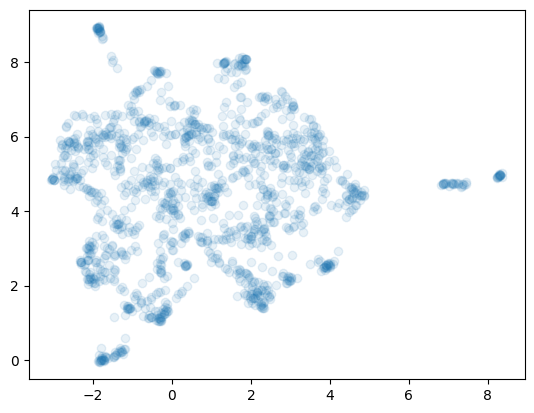

In [131]:
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],alpha=0.1)
plt.show()

# Part 5: Clustering 

In [132]:
import genieclust
g = genieclust.Genie(n_clusters=10, gini_threshold=0.3)
cluster_labels = g.fit_predict(umap_embeddings)
print(cluster_labels)

[0 1 2 ... 8 7 0]


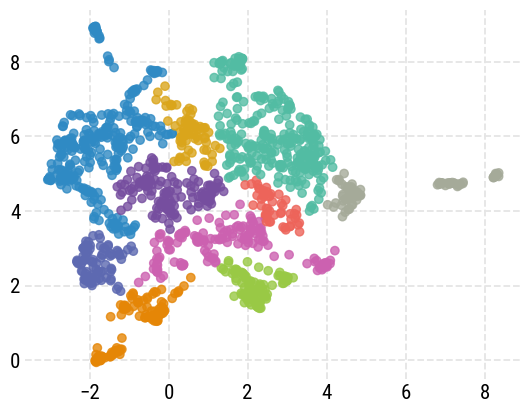

In [147]:
plt.scatter(x=umap_embeddings[:, 0], 
            y=umap_embeddings[:, 1],
            c=cluster_labels,
            cmap=colormaps.vivid,
            alpha=0.8)

# Part 6: Labeling clusters

In [134]:
# Read OpenAI API key from API_KEYS.txt file
with open('API_KEYS.txt', 'r') as file:
    for line in file:
        if line.startswith('OPENAI:'):
            openai_api_key = line.split(':', 1)[1].strip()
            break
    else:
        raise ValueError("OPENAI API key not found in API_KEYS.txt")

os.environ["OPENAI_API_KEY"] = openai_api_key

In [135]:
from litellm import completion
import pandas as pd
import random
import json

# Create a function to label clusters using OpenAI
def label_cluster(cluster_texts, cluster_id, n_samples=10):
    # Randomly sample representative texts from the cluster (max 10 for efficiency)
    sample_size = min(10, len(cluster_texts))
    sample_texts = random.sample(cluster_texts, sample_size)
    
    # Truncate texts to 100 characters
    sample_texts = [text[:1000] + "..." if len(text) > 1000 else text for text in sample_texts]
    
    prompt = f"""
    Below are randomly sampled texts from cluster {cluster_id}. Please analyze these texts and provide:
    1. A short descriptive label (2-4 words) for this cluster
    2. A brief description of the main theme

    Texts:
    {chr(10).join([f"- {text[:200]}..." if len(text) > 200 else f"- {text}" for text in sample_texts])}
    
    Please respond in JSON format:
    {{
        "label": "[your label]",
        "description": "[your description]"
    }}
    """
    
    messages = [{"content": prompt, "role": "user"}]
    response = completion(model="openai/gpt-5", messages=messages, response_format={"type": "json_object"})
    return response.choices[0].message.content

# Group texts by cluster
cluster_groups = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_groups:
        cluster_groups[label] = []
    cluster_groups[label].append(text_data[i])

# Label each cluster
cluster_info = {}
for cluster_id, texts in cluster_groups.items():
    print(f"Labeling cluster {cluster_id} ({len(texts)} texts)...")
    label_info = label_cluster(texts, cluster_id, n_samples=5)
    cluster_info[cluster_id] = label_info
    print(f"Cluster {cluster_id}: {label_info}\n")

# Create a summary dataframe
cluster_summary = []
for cluster_id, info in cluster_info.items():
    # Parse the JSON response
    try:
        parsed_info = json.loads(info)
        label = parsed_info.get('label', 'Unknown')
        description = parsed_info.get('description', 'No description available')
    except (json.JSONDecodeError, TypeError):
        # Fallback if JSON parsing fails
        label = f"Cluster {cluster_id}"
        description = str(info)
    
    cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Size': len(cluster_groups[cluster_id]),
        'Label': label,
        'Description': description
    })

cluster_df = pd.DataFrame(cluster_summary)
cluster_df

Labeling cluster 0 (115 texts)...


Cluster 0: {
  "label": "Medieval–Renaissance Philosophy",
  "description": "Biographical and thematic entries on key thinkers from the 11th–17th centuries in the Latin West and Islamic/Jewish traditions, highlighting scholasticism, humanism, natural philosophy, political/legal theory, and the Arabic–Latin translation movement’s cross-cultural influence."
}

Labeling cluster 1 (93 texts)...
Cluster 1: {
  "label": "Ancient and Medieval Philosophy",
  "description": "Articles on classical, late antique, and medieval philosophical figures and themes—covering biographical entries (e.g., Epicurus, Plutarch, Philoponus, Lipsius) and topics like soul, atomism, empiricism, practical reason, friendship/eros, and humor."
}

Labeling cluster 2 (283 texts)...
Cluster 2: {
  "label": "Moral and Political Philosophy",
  "description": "Contemporary work on ethics and political theory, spanning metaethics and practical reason to issues of character, motivation, coercion, rights and reparations, plus

,Cluster_ID,Size,Label,Description
0,0,115,Medieval–Renaissance Philosophy,Biographical and thematic entries on key think...
1,1,93,Ancient and Medieval Philosophy,"Articles on classical, late antique, and medie..."
2,2,283,Moral and Political Philosophy,Contemporary work on ethics and political theo...
3,3,96,Continental Philosophy Figures,Encyclopedic profiles of major European philos...
4,4,157,Philosophy Encyclopedia Topics,Encyclopedia-style overviews of major philosop...
5,5,79,Philosophy of Mind,Cluster centers on the nature and contents of ...
6,6,300,"Logic, Language, Mathematics",Cluster of analytic-philosophy topics centered...
7,7,141,"Science, Metaphysics, Theology",Analytic-philosophy topics spanning philosophy...
8,8,51,History of Ethics,Biographical and thematic entries on moral phi...
9,9,88,Feminist and Non-Western Philosophy,Articles blending feminist philosophical appro...


In [136]:
# Create a labels list from cluster_labels and the labeled cluster descriptions
labels_list = []
for cluster_id in cluster_labels:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    if not cluster_row.empty:
        label = cluster_row.iloc[0]['Label']
    else:
        label = f"Cluster {cluster_id}"
    labels_list.append(label)


# Part 7: Visualizing

<InteractiveFigure width=100% height=800>
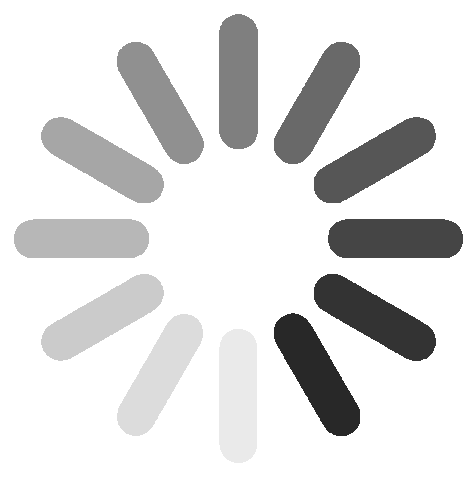

In [137]:
import datamapplot

datamapplot.create_interactive_plot(
    umap_embeddings,
    labels_list,  # label layer
    hover_text=title_data,  # hover_text must be the 2nd positional

    title=used_dataset
)